In [1]:
import math
import torch
from torch import nn
import torch.distributions as D

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

from einops import rearrange
import numpy as np

In [2]:
device = torch.device("cuda:2")

### Define Diffusion

In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start=-3, end=3, tau=1):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [4]:
class DiffusionModel(nn.Module):
    def __init__(
        self,
        *,
        model: nn.Module,
        target_size: int,
        objective,
        beta_schedule,
        ddim_steps,
        schedule_fn_kwargs = dict(),
        timesteps = 1000,
        ddim_sampling_eta = 0.0,
    ):
        super().__init__()

        self.model = model
        self.target_size = target_size
        self.dummy_param = nn.Parameter(torch.zeros(0))
        self.objective = objective
        assert objective in {"pred_noise", "pred_x0"}, \
            "objective must be either pred_noise (predict noise) or " \
            "pred_x0 (predict image start)"
        
        if beta_schedule == "linear":
            beta_schedule_fn = linear_beta_schedule
        elif beta_schedule == "cosine":
            beta_schedule_fn = cosine_beta_schedule
        elif beta_schedule == "sigmoid":
            beta_schedule_fn = sigmoid_beta_schedule
        else:
            raise ValueError(f"unknown beta schedule {beta_schedule}")

        betas = beta_schedule_fn(timesteps, **schedule_fn_kwargs)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters
        self.sampling_timesteps = ddim_steps
        assert self.sampling_timesteps <= timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))
        register_buffer("betas", betas)
        register_buffer("alphas_cumprod", alphas_cumprod)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))
        register_buffer("sqrt_recip_alphas_cumprod", torch.sqrt(1.0 / alphas_cumprod))
        register_buffer("sqrt_recipm1_alphas_cumprod", torch.sqrt(1.0 / alphas_cumprod - 1))

    @property
    def device(self):
        return self.dummy_param.device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )
    
    def _clip_func(self, x):
        return x.clamp(min=-1.0, max=1.0)

    def model_predictions(self, x, t, 
                          clip_x_start=False, 
                          rederive_pred_noise=False):
        model_output = self.model(x, t)
        maybe_clip = self._clip_func if clip_x_start else identity

        if self.objective == "pred_noise":
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)
            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)
        elif self.objective == "pred_x0":
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return pred_noise, x_start, model_output

    @torch.inference_mode()
    def ddim_sample(self, batch_size, return_inter_output):
        times = torch.linspace(-1, self.num_timesteps - 1, 
                               steps=self.sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]
        assert time_pairs[-1][1] == -1

        xt = torch.randn([batch_size, self.target_size], 
                         device=self.device)
        x_start = None
        inter_output = []
        for time, time_next in time_pairs:
            time_cond = torch.full((xt.shape[0],), time, 
                                   device=self.device, 
                                   dtype=torch.long)
            pred_noise, x_start, model_output = self.model_predictions(xt, time_cond,
                                                                       clip_x_start=True, 
                                                                       rederive_pred_noise=True)

            if time_next < 0:
                assert time_pairs[-1][1] == time_next
                if return_inter_output:
                    inter_output.append({
                        "pred_noise": pred_noise.cpu(),
                        "x_start": x_start.cpu(),
                        "model_output": model_output.cpu(),
                        "alpha": None,
                        "alpha_next": None,
                        "sigma": None,
                        "c": None,
                        "xt": x_start.cpu(),
                    })
                break

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]
            sigma = self.ddim_sampling_eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()
            noise = torch.randn_like(xt)
            xt = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise
            if return_inter_output:
                inter_output.append({
                    "pred_noise": pred_noise.cpu(),
                    "x_start": x_start.cpu(),
                    "model_output": model_output.cpu(),
                    "alpha": alpha,
                    "alpha_next": alpha_next,
                    "sigma": sigma,
                    "c": c,
                    "xt": xt.cpu(),
                })
        return {
            "x_start": x_start,
            "inter_output": inter_output,
        }

    @torch.inference_mode()
    def sample(self, batch_size, return_inter_output):
        return self.ddim_sample(batch_size, return_inter_output)

    def q_sample(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def forward(self, target):
        b = target.shape[0]
        assert target.shape[1] == self.target_size
        t = torch.randint(0, self.num_timesteps, (b,), device=target.device).long()
        
        noise = torch.randn_like(target)

        # noise sample
        noised_target = self.q_sample(x_start=target, t=t, noise=noise)

        # predict
        _pred_noise, _x_start, model_output = self.model_predictions(
            noised_target, t,
            clip_x_start=True, 
            rederive_pred_noise=True)
        
        if self.objective == "pred_noise":
            cur_target = noise
        elif self.objective == "pred_x0":
            cur_target = target
        else:
            raise ValueError(f"unknown objective {self.objective}")

        assert model_output.shape == cur_target.shape
        loss = (model_output - cur_target) ** 2
        return loss

In [5]:
class DenseModel(nn.Module):
    def __init__(self, target_size, hidden_dim, inter_layers):
        super().__init__()
        self.linears = nn.Sequential(
            nn.Linear(target_size + 1, hidden_dim),
            nn.ReLU(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU()
              ) for _ in range(inter_layers)],
            nn.Linear(hidden_dim, target_size)
        )
        
    def forward(self, x, t):
        return self.linears(torch.cat([x, t.unsqueeze(-1)], dim=-1))

In [6]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers=2, channels=128):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=channels)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(channels)[None])
        self.input_embed = nn.Linear(int(np.prod(data_shape)), channels)
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
        self.layers = nn.Sequential(
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(channels, channels), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(channels, int(np.prod(data_shape))),
        )

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        sin_embed_cond = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        cos_embed_cond = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_cond = self.timestep_embed(
            rearrange([sin_embed_cond, cos_embed_cond], "d b w -> b (d w)")
        )
        embed_ins = self.input_embed(x.view(x.shape[0], -1))
        out = self.layers(embed_ins + embed_cond)
        return out.view(x.shape)

### Test X

In [ ]:
target_size = 2

In [ ]:
def craft_gmm():
    means = torch.tensor([
        [3.0, 3.0],
        [-3.0, -3.0],
        [3.0, -3.0],
        [-3.0, 3.0]
    ], device=device)

    covariances = torch.stack([
        torch.tensor([[2.0, 1.0],
                    [1.0, 2.0]], device=device),
        torch.tensor([[2.0, 1.0],
                    [1.0, 2.0]], device=device),
        torch.tensor([[2.0, -1.0],
                    [-1.0, 2.0]], device=device),
         torch.tensor([[2.0, -1.0],
                    [-1.0, 2.0]], device=device),
    ], dim=0)

    mix = D.Categorical(probs=torch.tensor([0.25, 0.25, 0.25, 0.25], device=device))
    comp = D.MultivariateNormal(loc=means, covariance_matrix=covariances)
    return D.MixtureSameFamily(mix, comp)

In [ ]:
gmm = craft_gmm()

In [ ]:
gmm_samples = gmm.sample((10000, )).clamp(min=-10.0, max=10.0).cpu()
gmm_samples /= 10.0
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(gmm_samples)
plt.show()

In [ ]:
# dense_model = DenseModel(target_size=target_size, 
#                          hidden_dim=256, 
#                          inter_layers=5).to(device=device)
dense_model = FourierMLP(data_shape=[target_size],
                         num_layers=3,
                         channels=128).to(device=device)
optimizer = torch.optim.Adam(dense_model.parameters(), 
                             lr=1e-3, amsgrad=True)
diffusion_model = DiffusionModel(model=dense_model,
                                 target_size=target_size,
                                 objective="pred_noise",
                                 beta_schedule="linear",
                                 ddim_steps=1000,
                                 timesteps=1000,
                                 ddim_sampling_eta=1.0).to(device=device)

In [ ]:
steps = 10_000
batch_size = 1024
training_losses = []
diffusion_model.train()
for s in range(steps):
    gmm_samples = gmm.sample((batch_size, )).clamp(min=-10.0, max=10.0)
    gmm_samples /= 10.0
    
    optimizer.zero_grad()
    loss = diffusion_model(gmm_samples)
    loss = loss.sum(dim=-1).mean()
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

In [ ]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
diffusion_model.eval()
ddim_samples = []
for _ in range(10):
    with torch.inference_mode():
        ddim_samples.append(diffusion_model.sample(batch_size=1000, 
                                                   return_inter_output=True))

In [ ]:
x_starts = torch.cat([d["x_start"].cpu() for d in ddim_samples], dim=0)

In [ ]:
x_starts.shape

In [ ]:
plt.scatter(x_starts[:, 0],
            x_starts[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(x_starts)
plt.show()

### Test Moons

In [ ]:
target_size = 2

In [ ]:
m, _ = datasets.make_moons(n_samples=10_000, noise=0.05)

In [ ]:
def normalize_moons(moons: torch.Tensor):
    m = moons.clone()
    m[:, 0].clamp_(min=-1.5, max=2.5)
    m[:, 1].clamp_(min=-0.75, max=1.5)
    m[:, 0] += 1.5
    m[:, 1] += 0.75
    m[:, 0] /= 4.0
    m[:, 1] /= 2.25
    m *= 2.0
    m -= 1.0

    return m

In [ ]:
m = torch.from_numpy(m)
m = normalize_moons(m)

In [ ]:
plt.scatter(m[:, 0], m[:, 1],
            s=0.5, alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(m)
plt.show()

In [ ]:
# dense_model = DenseModel(target_size=target_size, 
#                          hidden_dim=128, 
#                          inter_layers=4).to(device=device)
dense_model = FourierMLP(data_shape=[target_size],
                         num_layers=3,
                         channels=128).to(device=device)
optimizer = torch.optim.Adam(dense_model.parameters(), 
                             lr=1e-3, amsgrad=True)
diffusion_model = DiffusionModel(model=dense_model,
                                 target_size=target_size,
                                 objective="pred_noise",
                                 beta_schedule="linear",
                                 ddim_steps=1000,
                                 timesteps=1000,
                                 ddim_sampling_eta=1.0).to(device=device)

In [ ]:
steps = 10_000
batch_size = 1024
training_losses = []
diffusion_model.train()
for s in range(steps):
    m, _ = datasets.make_moons(n_samples=batch_size, noise=0.05)
    m = torch.from_numpy(m).float().to(device=device)
    m = normalize_moons(m)
    
    optimizer.zero_grad()
    loss = diffusion_model(m)
    loss = loss.sum(dim=-1).mean()
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

In [ ]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
diffusion_model.eval()
ddim_samples = []
for _ in range(10):
    with torch.inference_mode():
        ddim_samples.append(diffusion_model.sample(batch_size=1000, 
                                                   return_inter_output=True))

In [ ]:
x_starts = torch.cat([d["x_start"].cpu() for d in ddim_samples], dim=0)

In [ ]:
plt.scatter(x_starts[:, 0],
            x_starts[:, 1],
            s=0.2,
            alpha=0.8)
plt.show()

In [ ]:
sns.kdeplot(x_starts)
plt.show()

### Test Roll

In [21]:
target_size = 2

In [22]:
def spirals_sample(n_samples):
    n = np.sqrt(np.random.rand(n_samples // 2, 1)) * 540 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
    d1y = np.sin(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
    x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
    x += np.random.randn(*x.shape) * 0.1
    return x

In [23]:
roll = spirals_sample(n_samples=10_000)

In [24]:
def normalize_roll(roll: torch.Tensor):
    r = roll.clone()
    r.clamp_(min=-3.0, max=3.0)
    return r / 3.0

In [25]:
roll = torch.from_numpy(roll)
roll = normalize_roll(roll)

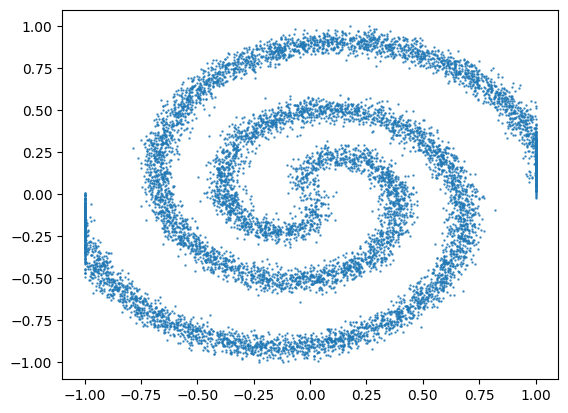

In [26]:
plt.scatter(roll[:, 0],
            roll[:, 1],
            s=0.5,
            alpha=0.8)
plt.show()

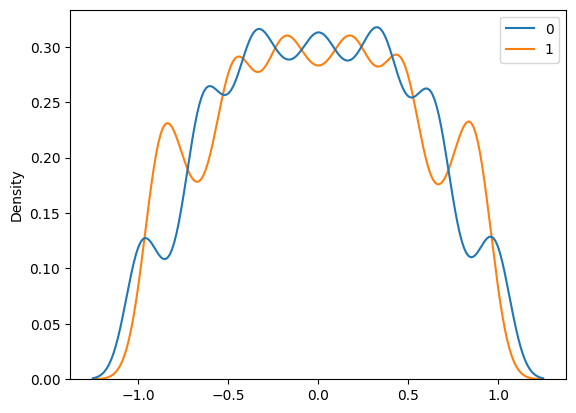

In [27]:
sns.kdeplot(roll)
plt.show()

In [28]:
# dense_model = DenseModel(target_size=target_size, 
#                          hidden_dim=128, 
#                          inter_layers=4).to(device=device)
dense_model = FourierMLP(data_shape=[target_size],
                         num_layers=3,
                         channels=180).to(device=device)
optimizer = torch.optim.Adam(dense_model.parameters(), 
                             lr=1e-2, amsgrad=True)
diffusion_model = DiffusionModel(model=dense_model,
                                 target_size=target_size,
                                 objective="pred_noise",
                                 beta_schedule="linear",
                                 ddim_steps=500,
                                 timesteps=1000,
                                 ddim_sampling_eta=1.0).to(device=device)

In [29]:
steps = 10_000
batch_size = 5000
training_losses = []
diffusion_model.train()
for s in range(steps):
    roll = spirals_sample(n_samples=batch_size)
    roll = torch.from_numpy(roll).float().to(device=device)
    roll = normalize_roll(roll)
    
    optimizer.zero_grad()
    loss = diffusion_model(roll)
    loss = loss.sum(dim=-1).mean()
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

[step 1000/10000] loss: 3.426e-01
[step 2000/10000] loss: 3.321e-01
[step 3000/10000] loss: 3.637e-01
[step 4000/10000] loss: 3.411e-01
[step 5000/10000] loss: 3.424e-01
[step 6000/10000] loss: 3.379e-01
[step 7000/10000] loss: 3.304e-01
[step 8000/10000] loss: 3.504e-01
[step 9000/10000] loss: 3.436e-01
[step 10000/10000] loss: 3.500e-01


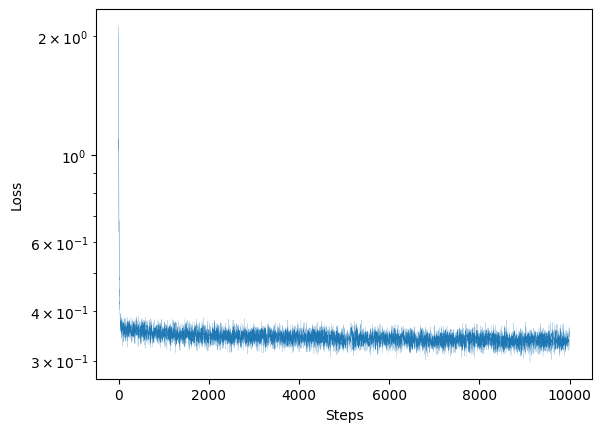

In [30]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [31]:
diffusion_model.eval()
ddim_samples = []
for _ in range(50):
    with torch.inference_mode():
        ddim_samples.append(diffusion_model.sample(batch_size=1000, 
                                                   return_inter_output=True))

In [32]:
x_starts = torch.cat([d["x_start"].cpu() for d in ddim_samples], dim=0)

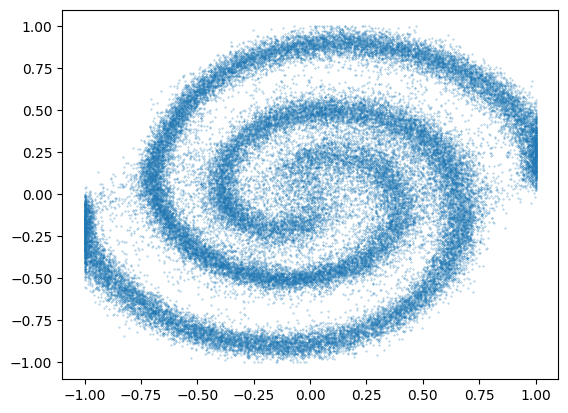

In [33]:
plt.scatter(x_starts[:, 0],
            x_starts[:, 1],
            s=0.1,
            alpha=0.6)
plt.show()

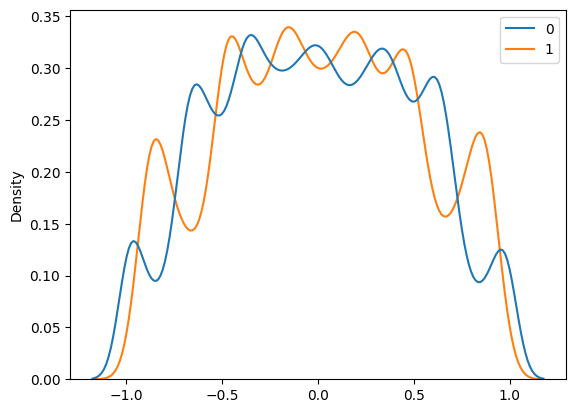

In [34]:
sns.kdeplot(x_starts)
plt.show()

### Test Sierpinski

In [ ]:
sierpinski = plt.imread("./sierpinski_hard.jpg")
plt.imshow(sierpinski)
plt.show()

In [ ]:
sierpinski = (torch.from_numpy(sierpinski) > 0).any(dim=-1).int()

In [ ]:
plt.imshow(sierpinski, interpolation="none")
plt.colorbar()
plt.show()

In [ ]:
sierpinski.shape

In [ ]:
sierpinski.nonzero().shape

### Test CheckerBoard

In [234]:
target_size = 2

In [235]:
def checkerboard_generate_sample(n_samples):
    x1 = np.random.rand(n_samples) * 4 - 2
    x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, n_samples) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    return np.concatenate([x1[:, None], x2[:, None]], 1) * 2

In [236]:
cb = checkerboard_generate_sample(n_samples=10_000)

In [237]:
def normalize_checkerboard(checkerboard: torch.Tensor):
    c = checkerboard.clone()
    c.clamp_(min=-4.0, max=4.0)
    return c / 4.0

In [238]:
cb = normalize_checkerboard(torch.from_numpy(cb))

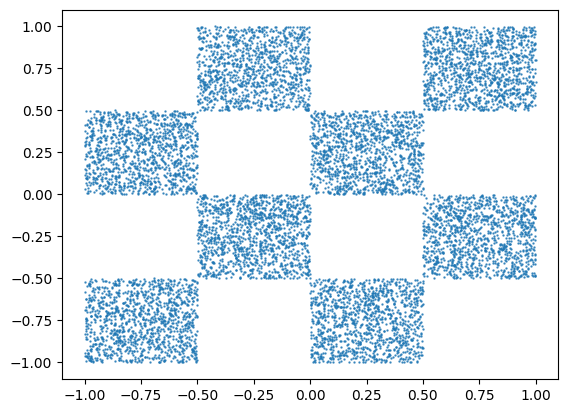

In [239]:
plt.scatter(cb[:, 0],
            cb[:, 1],
            s=0.5,
            alpha=0.8)
plt.show()

In [240]:
# dense_model = DenseModel(target_size=target_size, 
#                          hidden_dim=128, 
#                          inter_layers=4).to(device=device)
dense_model = FourierMLP(data_shape=[target_size],
                         num_layers=3,
                         channels=180).to(device=device)
optimizer = torch.optim.Adam(dense_model.parameters(), 
                             lr=1e-2, amsgrad=True)
diffusion_model = DiffusionModel(model=dense_model,
                                 target_size=target_size,
                                 objective="pred_noise",
                                 beta_schedule="cosine",
                                 ddim_steps=500,
                                 timesteps=1000,
                                 ddim_sampling_eta=1.0).to(device=device)

In [241]:
steps = 10_000
batch_size = 5000
training_losses = []
diffusion_model.train()
for s in range(steps):
    cb = checkerboard_generate_sample(n_samples=batch_size)
    cb = torch.from_numpy(cb).float().to(device=device)
    cb = normalize_checkerboard(cb)
    
    optimizer.zero_grad()
    loss = diffusion_model(cb)
    loss = loss.sum(dim=-1).mean()
    loss.backward()
    optimizer.step()

    training_losses.append(loss.item())

    if (s + 1) % 1000 == 0:
        print(f"[step {s + 1}/{steps}] loss: {loss.item():.3e}")

[step 1000/10000] loss: 6.505e-01
[step 2000/10000] loss: 6.606e-01
[step 3000/10000] loss: 6.617e-01
[step 4000/10000] loss: 6.530e-01
[step 5000/10000] loss: 6.693e-01
[step 6000/10000] loss: 6.367e-01
[step 7000/10000] loss: 6.790e-01
[step 8000/10000] loss: 6.579e-01
[step 9000/10000] loss: 6.491e-01
[step 10000/10000] loss: 6.581e-01


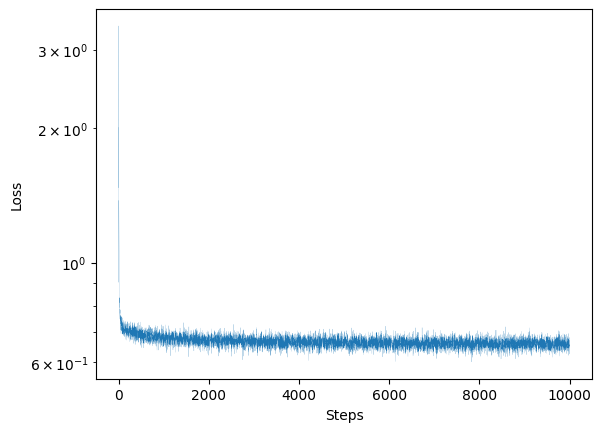

In [242]:
plt.plot(training_losses, linewidth=0.1)
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [243]:
diffusion_model.eval()
ddim_samples = []
for _ in range(50):
    with torch.inference_mode():
        ddim_samples.append(diffusion_model.sample(batch_size=1000, 
                                                   return_inter_output=True))

In [244]:
x_starts = torch.cat([d["x_start"].cpu() for d in ddim_samples], dim=0)

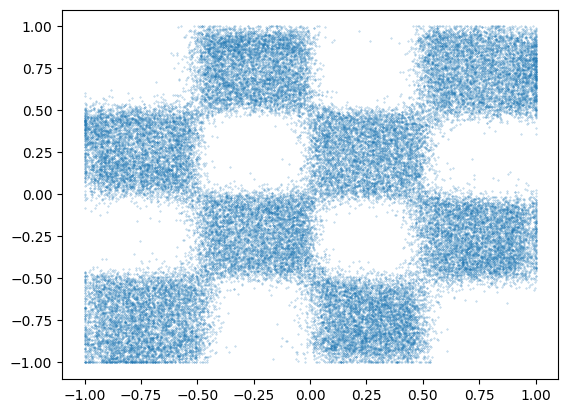

In [245]:
plt.scatter(x_starts[:, 0],
            x_starts[:, 1],
            s=0.1,
            alpha=0.5)
plt.show()